In [2]:
import pandas as pd

# Load the CSV files
species = pd.read_csv('species_info.csv')
observations = pd.read_csv('observations.csv')

In [3]:
# Preview the data
print(species.head())
print(species.info())

print(observations.head())
print(observations.info())

  category                scientific_name  \
0   Mammal  Clethrionomys gapperi gapperi   
1   Mammal                      Bos bison   
2   Mammal                     Bos taurus   
3   Mammal                     Ovis aries   
4   Mammal                 Cervus elaphus   

                                        common_names conservation_status  
0                           Gapper's Red-Backed Vole                 NaN  
1                              American Bison, Bison                 NaN  
2  Aurochs, Aurochs, Domestic Cattle (Feral), Dom...                 NaN  
3  Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)                 NaN  
4                                      Wapiti Or Elk                 NaN  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5824 entries, 0 to 5823
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   category             5824 non-null   object
 1   scientific_name      

In [4]:
# Fill NaN with 'No Intervention'
species['conservation_status'] = species['conservation_status'].fillna('No Intervention')

# Check for duplicate scientific names (species)
print(f"Duplicates: {species.duplicated('scientific_name').sum()}")

# Drop duplicates if needed
species = species.drop_duplicates('scientific_name')

# Quick overview
print(species['conservation_status'].value_counts())
print(species['category'].value_counts())


Duplicates: 283
conservation_status
No Intervention       5363
Species of Concern     151
Endangered              15
Threatened               9
In Recovery              3
Name: count, dtype: int64
category
Vascular Plant       4262
Bird                  488
Nonvascular Plant     333
Mammal                176
Fish                  125
Amphibian              79
Reptile                78
Name: count, dtype: int64


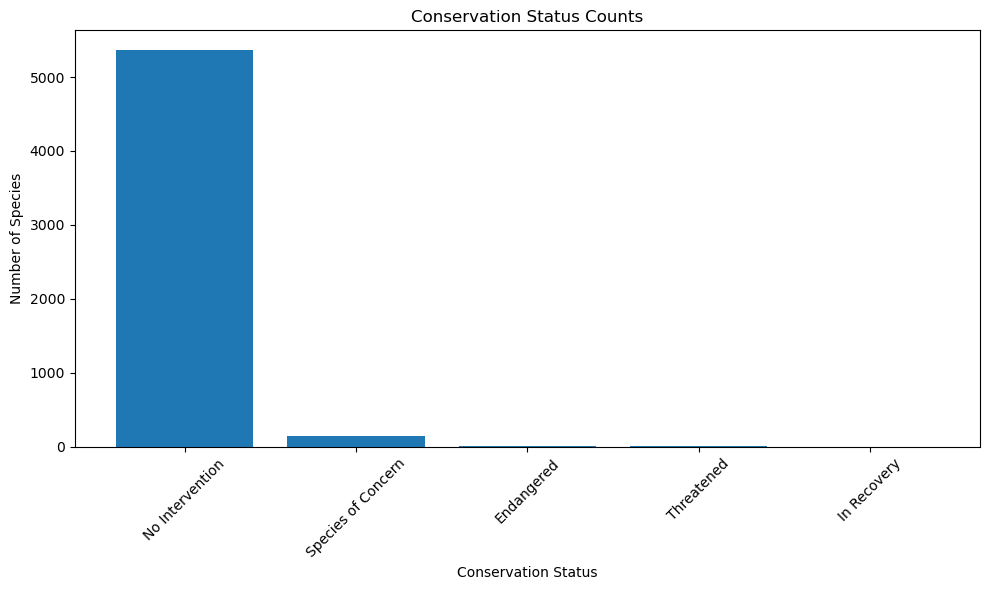

In [5]:
import matplotlib.pyplot as plt

# Group and count species by conservation_status
status_counts = species['conservation_status'].value_counts().reset_index()
status_counts.columns = ['conservation_status', 'count']

# Plot
plt.figure(figsize=(10, 6))
plt.bar(status_counts['conservation_status'], status_counts['count'])
plt.title('Conservation Status Counts')
plt.xlabel('Conservation Status')
plt.ylabel('Number of Species')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [6]:
# Merge on scientific_name to get status + park + observations
merged = pd.merge(observations, species, how='left', on='scientific_name')

# Preview merged dataset
print(merged.head())


            scientific_name                            park_name  \
0        Vicia benghalensis  Great Smoky Mountains National Park   
1            Neovison vison  Great Smoky Mountains National Park   
2         Prunus subcordata               Yosemite National Park   
3      Abutilon theophrasti                  Bryce National Park   
4  Githopsis specularioides  Great Smoky Mountains National Park   

   observations        category                        common_names  \
0            68  Vascular Plant  Purple Vetch, Reddish Tufted Vetch   
1            77          Mammal                       American Mink   
2           138  Vascular Plant                        Klamath Plum   
3            84  Vascular Plant                          Velvetleaf   
4            85  Vascular Plant                      Common Bluecup   

  conservation_status  
0     No Intervention  
1     No Intervention  
2     No Intervention  
3     No Intervention  
4     No Intervention  


In [7]:
# Define list of protected statuses
protected_statuses = ['Endangered', 'Threatened', 'In Recovery', 'Species of Concern']

# Create new boolean column
merged['is_protected'] = merged['conservation_status'].isin(protected_statuses)


In [8]:
# Group by park and protection status
protected_obs_by_park = (
    merged[merged['is_protected']]
    .groupby('park_name')['observations']
    .sum()
    .reset_index()
    .sort_values(by='observations', ascending=False)
)

print(protected_obs_by_park)


                             park_name  observations
2            Yellowstone National Park         38663
3               Yosemite National Park         23356
0                  Bryce National Park         16099
1  Great Smoky Mountains National Park         11177


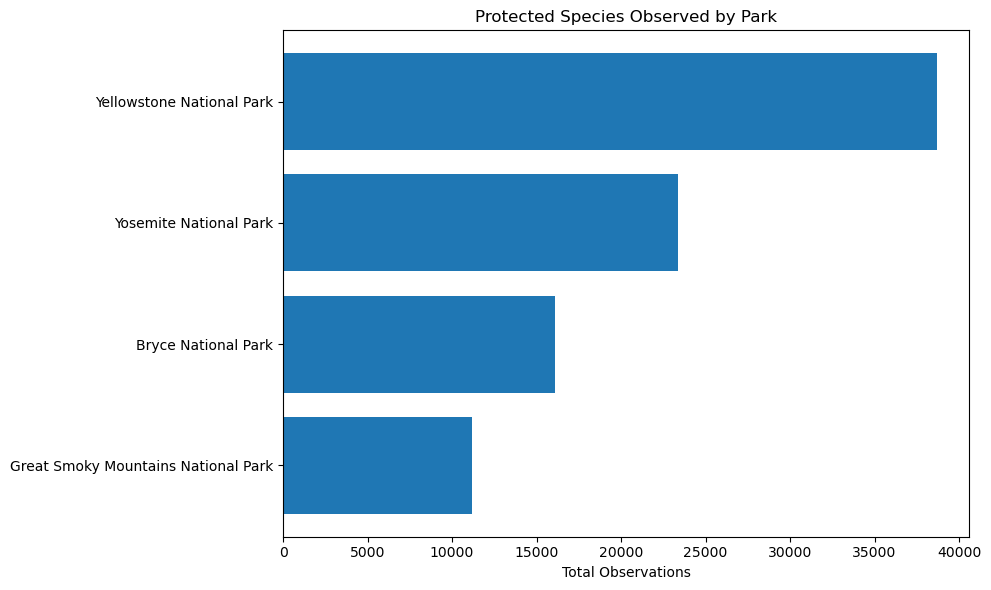

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.barh(protected_obs_by_park['park_name'], protected_obs_by_park['observations'])
plt.xlabel('Total Observations')
plt.title('Protected Species Observed by Park')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [10]:
# Group by park and category, summing observations
category_by_park = (
    merged.groupby(['park_name', 'category'])['observations']
    .sum()
    .reset_index()
)

# Pivot to see categories as columns
pivot = category_by_park.pivot(index='park_name', columns='category', values='observations').fillna(0)

# Display
print(pivot)


category                             Amphibian    Bird   Fish  Mammal  \
park_name                                                               
Bryce National Park                       7380   51647  12423   20550   
Great Smoky Mountains National Park       5707   37728   9206   15012   
Yellowstone National Park                19440  127251  30574   50795   
Yosemite National Park                   11444   76207  18615   30339   

category                             Nonvascular Plant  Reptile  \
park_name                                                         
Bryce National Park                              32992     7950   
Great Smoky Mountains National Park              24857     5691   
Yellowstone National Park                        83021    19554   
Yosemite National Park                           49783    11483   

category                             Vascular Plant  
park_name                                            
Bryce National Park                          44308

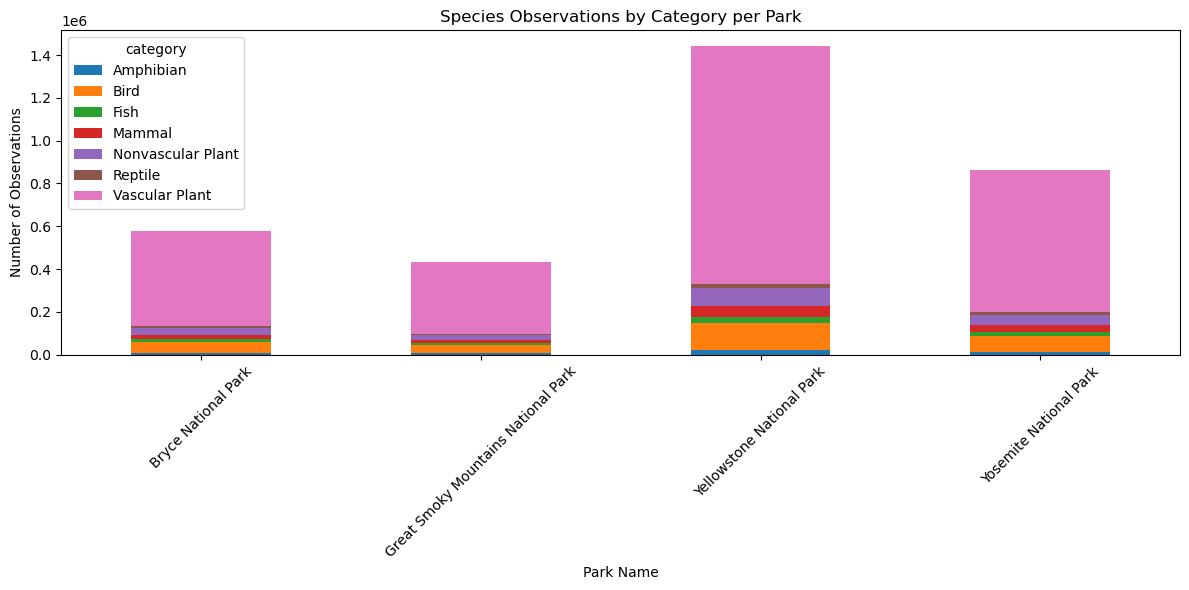

In [11]:
pivot.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Species Observations by Category per Park')
plt.ylabel('Number of Observations')
plt.xlabel('Park Name')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [12]:
# Group by is_protected and sum observations
obs_by_protection = (
    merged.groupby('is_protected')['observations']
    .sum()
    .reset_index()
)

print(obs_by_protection)


   is_protected  observations
0         False       3225444
1          True         89295


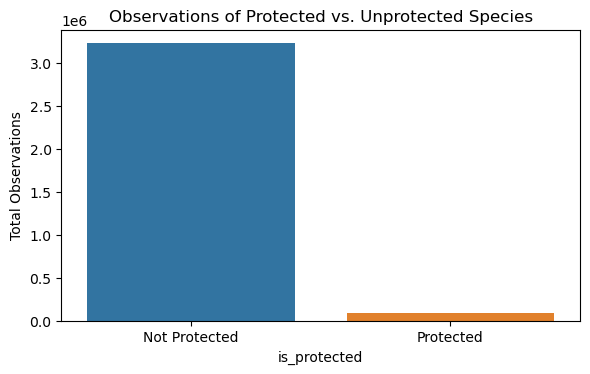

In [13]:
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.barplot(data=obs_by_protection, x='is_protected', y='observations')
plt.xticks([0, 1], ['Not Protected', 'Protected'])
plt.ylabel('Total Observations')
plt.title('Observations of Protected vs. Unprotected Species')
plt.tight_layout()
plt.show()


In [14]:
top_species = (
    merged.groupby(['common_names', 'scientific_name'])['observations']
    .sum()
    .reset_index()
    .sort_values(by='observations', ascending=False)
    .head(10)
)

print(top_species)


                               common_names        scientific_name  \
1929                 Eurasian Collared-Dove  Streptopelia decaocto   
1407       Common Velvet Grass, Velvetgrass         Holcus lanatus   
138                 American Beaver, Beaver      Castor canadensis   
1141           Cat's Ear, Spotted Cat's-Ear   Hypochaeris radicata   
3633                Panther (Mountain Lion)          Puma concolor   
1379                Common Raccoon, Raccoon          Procyon lotor   
4053                              Rock Dove          Columba livia   
2920  Little Brown Bat, Little Brown Myotis       Myotis lucifugus   
4747   Stick-Tight, Three-Lobe Beggar-Ticks      Bidens tripartita   
1679     Dillen's Woodsorrel, Yellow Sorrel        Oxalis dillenii   

      observations  
1929          1785  
1407          1780  
138           1725  
1141          1720  
3633          1711  
1379          1692  
4053          1653  
2920          1547  
4747          1296  
1679          1276 

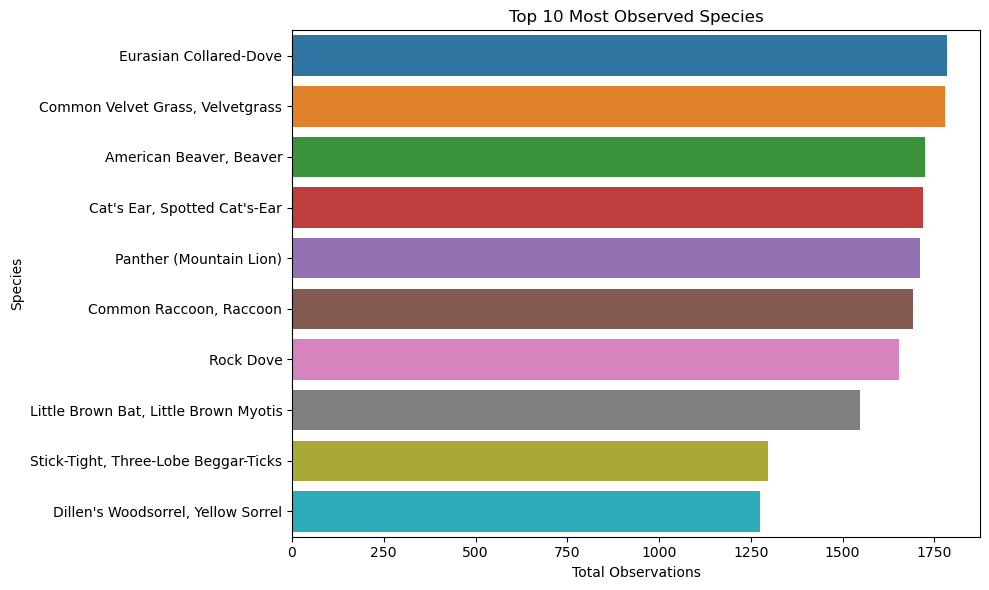

In [15]:
plt.figure(figsize=(10, 6))
sns.barplot(data=top_species, y='common_names', x='observations')
plt.xlabel('Total Observations')
plt.ylabel('Species')
plt.title('Top 10 Most Observed Species')
plt.tight_layout()
plt.show()


In [16]:
# Filter to endangered species only
endangered = merged[merged['conservation_status'] == 'Endangered']

# Group by category and sum observations
endangered_by_category = (
    endangered.groupby('category')['observations']
    .sum()
    .reset_index()
    .sort_values(by='observations', ascending=False)
)

print(endangered_by_category)


         category  observations
3          Mammal          1463
1            Bird           574
2            Fish           455
4  Vascular Plant           162
0       Amphibian           144


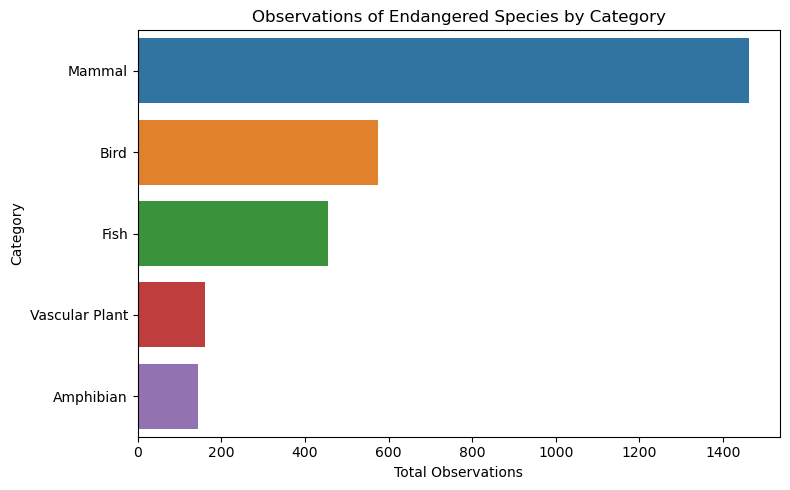

In [17]:
plt.figure(figsize=(8, 5))
sns.barplot(data=endangered_by_category, x='observations', y='category')
plt.title('Observations of Endangered Species by Category')
plt.xlabel('Total Observations')
plt.ylabel('Category')
plt.tight_layout()
plt.show()
